In [1]:
import ROOT
import sys
import math
from DataFormats.FWLite import Events, Handle
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Welcome to JupyROOT 6.12/07


In [2]:
#ROOT C++ library
ROOT.gSystem.Load("libFWCoreFWLite.so");
ROOT.gSystem.Load("libDataFormatsFWLite.so");
ROOT.FWLiteEnabler.enable()

In [3]:
#global parameters
m0=0.5
E0=1
NH=50

In [4]:
def rescale(cons,mj):
    scfactors=m0/mj
    rs_cons=ROOT.TLorentzVector()
    rs_cons.SetPxPyPzE(cons.px()*scfactors,cons.py()*scfactors,cons.pz()*scfactors,cons.energy()*scfactors)
    return rs_cons

In [5]:
def Gamma(PJ): #rescaled
    P0=math.sqrt(E0*E0-m0*m0)
    return (PJ.E()*E0-PJ.P()*P0)/(PJ.M()*m0) #or m0*m0 ?

In [6]:
def boostVec(tj,gamma):
    tmp = tj.P()/math.sqrt(1-(1/(gamma*gamma)))
    bv = ROOT.TVector3()
    bv.SetXYZ(tj.Px()/tmp,tj.Py()/tmp,tj.Pz()/tmp)
    return bv

In [7]:
#Gram-Schmidt
def newbasis(l,j):
    e1=j.Vect().Unit()
    c2=l[0][1].Vect().Dot(e1)
    v2=ROOT.TVector3()
    v2.SetXYZ(l[0][1].Vect().Px()-c2*e1.Px(),l[0][1].Vect().Py()-c2*e1.Py(),l[0][1].Vect().Pz()-c2*e1.Pz())
    e2=v2.Unit()
    c3_1=l[1][1].Vect().Dot(e1)
    c3_2=l[1][1].Vect().Dot(e2)
    v3=ROOT.TVector3()
    v3.SetXYZ(l[1][1].Vect().Px()-c3_1*e1.Px()-c3_2*e2.Px(),l[1][1].Vect().Py()-c3_1*e1.Py()-c3_2*e2.Py(),l[1][1].Vect().Pz()-c3_1*e1.Pz()-c3_2*e2.Pz())
    e3=v3.Unit()
    return((e2,e3,e1))

In [8]:
def isAncestor(a,p) :
        if a == p :
                return True
        for i in xrange(0,p.numberOfMothers()) :
                if isAncestor(a,p.mother(i)) :
                         return True
        return False

In [44]:
events = Events("root://cmsxrootd.fnal.gov//store/mc/RunIIFall17MiniAODv2/TTJets_HT-1200to2500_TuneCP5_13TeV-madgraphMLM-pythia8/MINIAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/100000/B43DB7F4-EF96-E811-8E08-0CC47A4C8E66.root")

In [9]:
data=[]
file = open('signal_miniaod.txt', 'r') 
#file = open('ttbar_semi.txt', 'r') 
dtct=0
for line in file: 
    data.append(line.replace('\n', '')) 
    dtct+=1
    if dtct==10:
        break
events = Events (data)

In [10]:
fatjets, fatjetLabel = Handle("std::vector<pat::Jet>"), "slimmedJetsAK8"
handlePruned  = Handle ("std::vector<reco::GenParticle>")
labelPruned = ("prunedGenParticles")
handlePacked  = Handle ("std::vector<pat::PackedGenParticle>")
labelPacked = ("packedGenParticles")

In [49]:
Fij=np.zeros((NH, NH))
mask=np.zeros((NH, NH))

In [50]:
for iev,event in enumerate(events):
    event.getByLabel(fatjetLabel, fatjets)
    event.getByLabel (labelPruned, handlePruned)
    event.getByLabel (labelPacked, handlePacked)
    #print "size ",len(fatjets.product())
    top=ROOT.TLorentzVector()
    #for p in handlePruned.product() :
    #    if abs(p.pdgId())==6:
    #        top.SetPxPyPzE(p.px(), p.py(), p.pz(), p.energy())
            #print p.pt()
            #for pa in handlePacked.product():
            #    mother = pa.mother(0)
                #if mother and isAncestor(p,mother) :
                #    if pa.pdgId()>5:
                #        top.SetPxPyPzE(p.px(), p.py(), p.pz(), p.energy())
    jetcount=0
    tjet=0
    tjet_Tlz=0
    drjet=0
    jPt=0
    for i,j in enumerate(fatjets.product()):
        if j.pt()<400:
            continue
        jetcount+=1
        jet=ROOT.TLorentzVector()
        jet.SetPxPyPzE(j.px(), j.py(), j.pz(), j.energy())
        #if jet.DeltaR(top)>drjet:
        if jet.Pt()>jPt:
            #drjet=jet.DeltaR(top)
            jPt=jet.Pt()
            tjet=j
            tjet_Tlz=jet
        #print jet.DeltaR(top),j.pt()
    if tjet==0:
        continue
    #print jetcount
    #print tjet.numberOfDaughters()
    
    r_J=rescale(tjet,tjet.mass())
    gm =Gamma(r_J)
    bv = boostVec(tjet_Tlz,gm)
    #print r_J.E(),r_J.M()
    if r_J.E()>E0:
        r_J.Boost(-bv)
    else:
        r_J.Boost(bv)
    #print "boosted ",r_J.E(),r_J.M()
    cons_list=[]
    for i in range(0,tjet.numberOfDaughters()):
        pd=tjet.daughter(i)
        dt=ROOT.TLorentzVector()
        dt.SetPxPyPzE(pd.px(), pd.py(), pd.pz(), pd.energy())
        cons_list.append((pd.energy(),dt))
    cons_list.sort(reverse=True)
    nb=newbasis(cons_list,r_J)
    r_conslist=[]
    for x in cons_list:
        old_v=(x[1].Px(),x[1].Py(),x[1].Pz())
        tmp = np.linalg.inv(np.array([nb[0], nb[1], nb[2]])).dot(old_v)
        r_c=ROOT.TLorentzVector()
        r_c.SetPxPyPzE(tmp[0], tmp[1], tmp[2], x[0])
        r_conslist.append(r_c)
    #print r_conslist
    #Fij=np.zeros((NH, NH))
    #mask=np.zeros((NH, NH))
    for ik,k in enumerate(r_conslist):
        xi=int(math.floor(0.5*(NH+1)+0.5*(NH-1)*nb[0].Dot(k.Vect().Unit())))
        yi=int(math.floor(0.5*(NH+1)+0.5*(NH-1)*nb[1].Dot(k.Vect().Unit())))
        #print xi,yi
        Fij[xi][yi]+=k.E()/E0
    #plt.imshow(Fij, cmap='hot', interpolation='nearest')
    #ax = sns.heatmap(Fij, mask=mask, linewidth=0.5)
    if iev>10000:
        break

Warning in <TLorentzVector::Compare>: this method must be overridden!
Warning in <TLorentzVector::Compare>: this method must be overridden!
Warning in <TLorentzVector::Compare>: this method must be overridden!
Warning in <TLorentzVector::Compare>: this method must be overridden!
Warning in <TLorentzVector::Compare>: this method must be overridden!
Warning in <TLorentzVector::Compare>: this method must be overridden!
Warning in <TLorentzVector::Compare>: this method must be overridden!


In [51]:
rows = Fij.shape[0]
cols = Fij.shape[1]
for i in range(rows):
    for j in range(cols):
        if Fij[i][j]>0:
            mask[i][j]=False
        else:
            mask[i][j]=True

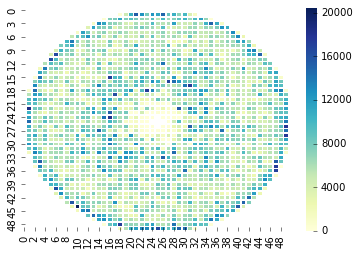

In [52]:
ax = sns.heatmap(Fij, mask=mask, linewidth=0.5,cmap="YlGnBu")
plt.show()